# Project for the retail store

The online store is launching a new service. Now users can edit and add product descriptions, just like in wiki communities. That is, clients suggest their edits and comment on the changes of others. The store needs a tool that will look for toxic comments and send them for moderation.

Train the model to classify comments into positive and negative. At your disposal is a set of data with markings about the toxicity of edits.

Build a model with a quality metric value *F1* of at least 0.75.

**Instructions for completing the project**

1. Download and prepare data.
2. Train different models.
3. Draw conclusions.

It is not necessary to use *BERT* to complete the project, but you can try.

**Description of data**

The data is in the file `toxic_comments.csv`. The *text* column in it contains the text of the comment, and *toxic* is the target attribute.

## Data preparation

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
import nltk
import time

RANDOM_STATE=12345

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
comm=pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
comm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
comm.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
comm.duplicated().sum()

0

In [6]:
comm.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
comm = comm.drop(['Unnamed: 0'], axis=1)

In [8]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    return text
    
def lemmatize_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z' ]+", ' ', text)
    text = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return text

In [9]:
from tqdm.notebook import tqdm
tqdm.pandas(desc="bar")

In [10]:
comm['lemm_text'] = comm['text'].progress_apply(lemmatize_text)

comm = comm.drop(['text'], axis=1)

bar:   0%|          | 0/159292 [00:00<?, ?it/s]

In [11]:
# код ревьюера, посмотрим что получилось

comm.head()

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d'aww he match this background colour i 'm see...
2,0,hey man i 'm really not try to edit war it 's ...
3,0,more i ca n't make any real suggestion on impr...
4,0,you sir be my hero any chance you remember wha...


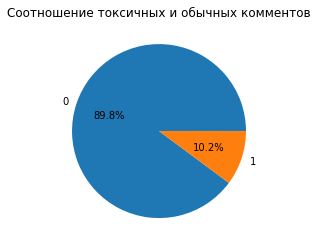

In [12]:
comments=comm['toxic'].value_counts()
labels=comments.index

plt.pie(comments, labels=labels, autopct='%.1f%%')
plt.title('Соотношение токсичных и обычных комментов')
plt.show()

### Conclusion

1. We studied the source data: there are no gaps or duplicates.
2. Removed the Unnamed column, which does not carry any semantic load.
3. It was noted that there are almost 9 times fewer toxic comments than correct ones. Let's take this observation into account when training models.

## Model training

In [13]:
target=comm['toxic']
features=comm.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, 
                                                                              random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,
                                                                            random_state=RANDOM_STATE)

bad_words=set(stopwords.words('english'))
td_idf=TfidfVectorizer(stop_words=bad_words)

features_train=td_idf.fit_transform(features_train['lemm_text'].values)
features_test=td_idf.transform(features_test['lemm_text'].values)
features_valid=td_idf.transform(features_valid['lemm_text'].values)

In [14]:
print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)

(127433, 132767)
(15930, 132767)
(15929, 132767)


### Logistic Regression

In [15]:
%%time
model_lr=LogisticRegression(class_weight='balanced', C=2, max_iter=1000)
model_lr.fit(features_train, target_train)
predicted=model_lr.predict(features_valid)
f1_lr=f1_score(predicted, target_valid)
f1_lr

CPU times: user 39.9 s, sys: 53.2 s, total: 1min 33s
Wall time: 1min 33s


0.7515612272603855

### Decision Tree

In [16]:
%%time
model_dt=DecisionTreeClassifier(class_weight='balanced', max_depth=10)
model_dt.fit(features_train, target_train)
predicted=model_dt.predict(features_valid)
f1_dt=f1_score(predicted, target_valid)
f1_dt

CPU times: user 6.49 s, sys: 21.4 ms, total: 6.51 s
Wall time: 6.52 s


0.5805668016194332

### Random Forest

In [17]:
%%time
model_rf=RandomForestClassifier(class_weight='balanced', max_depth=10)
model_rf.fit(features_train, target_train)
predicted=model_rf.predict(features_valid)
f1_rf=f1_score(predicted, target_valid)
f1_rf

CPU times: user 3.9 s, sys: 14.8 ms, total: 3.91 s
Wall time: 3.92 s


0.35477336034439094

### Conclusion

In [18]:
columns=['Logistic Regression', 'Decision Tree', 'Random Forest']
info={'Показатель f1 score':[f1_lr, f1_dt, f1_rf]}
final_result=pd.DataFrame(data=info, index=columns)
final_result

,Показатель f1 score
Logistic Regression,0.751561
Decision Tree,0.580567
Random Forest,0.354773


We trained 3 models: Logistic Regression, Decision Tree and Random Forest. The Decision Tree model performed best. To compensate for class imbalance, we used the parameter class_weight='balanced'

## Validation

In [19]:
%%time
predicted=model_lr.predict(features_test)
f1=f1_score(predicted, target_test)
f1

CPU times: user 7.27 ms, sys: 0 ns, total: 7.27 ms
Wall time: 6.82 ms


0.7558107738583538

## Conclusion

1. Analyzed the original for omissions and repetitions.
2. We lemmatized the text and also indicated stop words.
3. Trained 3 models. The Logistic Regression model turned out to be the highest quality. She takes longer to train than the others, but is significantly superior to them in accuracy.
4. We checked the resulting model on the validation sample and made sure that it worked correctly.